In [1]:
#MEMASUKKAN PUSTAKA YANG DIBUTUHKAN
import scipy
import numpy
import matplotlib
import sklearn
import statsmodels
from pandas import read_csv
from pandas import datetime
from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot


https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

In [2]:
#MEMBACA DATA MENTAH
series = read_csv('produksi-teh-indonesia.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#MENAMPILKAN WUJUD DATA MENTAH SEBAGIAN AWAL
print(series.head())

Tahun-Bulan
2006-01-01    12011
2006-02-01    14252
2006-03-01    17008
2006-04-01    15256
2006-05-01    14593
Name: Jumlah Ton, dtype: int64


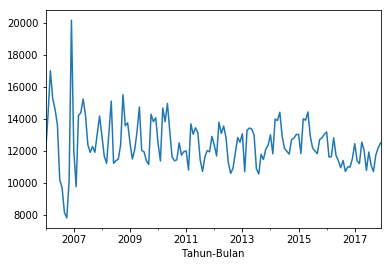

In [3]:
#MEMBUAT PLOT DATA MENTAH
series.plot()
pyplot.show()

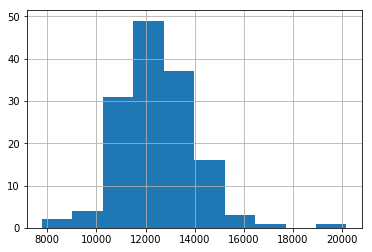

In [4]:
#MEMBUAT HISTROGRAM DATA MENTAH, PENGECEKAN KURVA GAUSSIAN
series.hist()
pyplot.show()

Tahun-Bulan
2006-01-01        NaN
2006-02-01        NaN
2006-03-01        NaN
2006-04-01        NaN
2006-05-01        NaN
2006-06-01        NaN
2006-07-01        NaN
2006-08-01        NaN
2006-09-01        NaN
2006-10-01        NaN
2006-11-01        NaN
2006-12-01    12732.5
Name: Jumlah Ton, dtype: float64


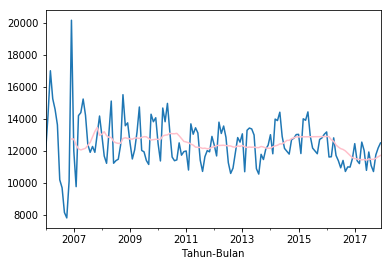

In [5]:
#MEMBUAT KURVA ROLLING-MEAN PER 12 BULAN
# Tail-rolling average transform
rolling = series.rolling(window=12)
rolling_mean = rolling.mean()
print(rolling_mean.head(12))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='pink')
pyplot.show()

#PROCESS DIFFERENCING, DATA MENTAH JADI DATA ADJUSTED
# seasonally adjust the time series
# seasonal difference
differenced = series.diff(12)
# trim off the first year of empty data
differenced = differenced[12:]
# save differenced dataset to file
differenced.to_csv('seasonally_adjusted_PredictTea.csv')
# plot differenced dataset
differenced.plot()
pyplot.show()

Tahun-Bulan
2006-01-01        NaN
2006-02-01        NaN
2006-03-01        NaN
2006-04-01        NaN
2006-05-01        NaN
2006-06-01        NaN
2006-07-01        NaN
2006-08-01        NaN
2006-09-01        NaN
2006-10-01        NaN
2006-11-01        NaN
2006-12-01    12732.5
Name: Jumlah Ton, dtype: float64


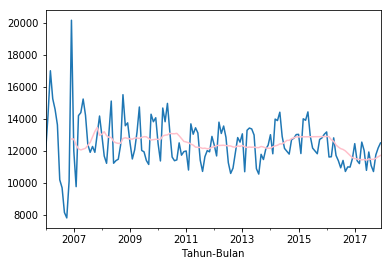

In [6]:
#MENAMPILKAN WUJUD DATA MODIF SEBAGIAN AWAL DAN PLOT ROLLING-MEAN
# Tail-rolling average transform
rolling = series.rolling(window=12)
rolling_mean = rolling.mean()
print(rolling_mean.head(12))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='pink')
pyplot.show()

In [7]:
# PENGECEKAN STASIONERITAS DENGAN AUGMENTED-DICKY FULLER TEST
from statsmodels.tsa.stattools import adfuller
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
#if result[1]>=result[4].items(1):
#    print('p-value > Critical Values: The data has a root unit and is a non-stationary')
#else:
#    print('p-value > Critical Values: The data does not has a root unit and is a stationary')
    
#https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -2.547192
p-value: 0.104410
Critical Values:
	5%: -2.884
	10%: -2.579
	1%: -3.482


#Jika P-Value > Critical Value 5%; Dilakukkan Logging memastikan kembali
#https://machinelearningmastery.com/time-series-data-stationary-python/
from numpy import log
X = adjseries.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
#PENGECEKAN FORMASI PARAMETER ARIMA TERBAIK UNTUK PEMODELAN DATA MODIF
import warnings
#from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1010447.697
ARIMA(0, 0, 1) MSE=730672.650
ARIMA(0, 0, 2) MSE=760714.474
ARIMA(0, 1, 0) MSE=755141.951
ARIMA(0, 1, 1) MSE=922609.108
ARIMA(0, 1, 2) MSE=695773.916
ARIMA(0, 2, 0) MSE=1908665.438
ARIMA(0, 2, 1) MSE=772478.774
ARIMA(1, 0, 0) MSE=686226.523
ARIMA(1, 0, 1) MSE=764917.692
ARIMA(1, 0, 2) MSE=785247.332
ARIMA(1, 1, 0) MSE=710102.356
ARIMA(1, 1, 1) MSE=662217.465
ARIMA(1, 1, 2) MSE=734290.130
ARIMA(1, 2, 0) MSE=1283287.294
ARIMA(2, 0, 0) MSE=764340.938
ARIMA(2, 0, 1) MSE=983410.809
ARIMA(2, 0, 2) MSE=978886.192
ARIMA(2, 1, 0) MSE=721480.593
ARIMA(2, 1, 1) MSE=726120.295
ARIMA(2, 1, 2) MSE=751855.728
ARIMA(2, 2, 0) MSE=1135176.612
ARIMA(4, 0, 0) MSE=872023.412
ARIMA(4, 0, 1) MSE=960593.312
ARIMA(4, 0, 2) MSE=1006447.182
ARIMA(4, 1, 0) MSE=740446.913
ARIMA(4, 1, 1) MSE=813677.071
ARIMA(4, 1, 2) MSE=804310.958
ARIMA(4, 2, 0) MSE=1060085.183
ARIMA(4, 2, 1) MSE=756023.774
ARIMA(6, 0, 0) MSE=909745.774
ARIMA(6, 0, 1) MSE=1014185.311
ARIMA(6, 1, 0) MSE=723577.705
ARI

In [ ]:
#!! https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ 

In [ ]:
#from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def parser(x):
	return datetime.strptime(x, '%Y-%m')

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()